In [1]:
#for development of the gridmap
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210314-114641.txt") #turns
sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210315-213733.txt") #backward from wall

In [2]:
from Gyrus import Gyrus
from TimeSeries import TimeSeries
import numpy as np

class Plotter(Gyrus):
    def __init__(self,vname,title,ylabel):
        self.value_name=vname
        self.dataseries=TimeSeries(title=title,ylabel=ylabel)
        
    
    def read_message(self,message):
        if self.value_name in message and "timestamp" in message:            
            self.dataseries.append(message["timestamp"],message[self.value_name])
        return []
    
class MotorPlotter(Gyrus):
    def __init__(self):
        self.value_name="drive/motors_active"
        ylabel="Motor fb active"
        title="Motors"
        self.dataseries=TimeSeries(title=title,ylabel=ylabel)
        
    
    def read_message(self,message):
        if self.value_name in message and "timestamp" in message:            
            self.dataseries.append(message["timestamp"],message[self.value_name][0])
        return []
    
class UltrasonicPlotter(Gyrus):
    def __init__(self):
        self.value_name="ultrasonic_sensor/last_measurement"
        self.dataseries=TimeSeries(title="Ultrasonic Distance",ylabel="Distance (m)")
        self.dataseries_unc=TimeSeries(title="Ultrasonic Distance Unc",ylabel="Distance (m)")
        self.last_timestamp=-1
        
    def read_message(self,message):
        if self.value_name in message and "timestamp" in message:            
            if self.last_timestamp!=message[self.value_name]["timestamp"]:
                self.dataseries.append(message["timestamp"],message[self.value_name]["average_distance"])
                self.dataseries_unc.append(message["timestamp"],message[self.value_name]["stdev_distance"])
                self.last_timestamp=message[self.value_name]["timestamp"]
            else:
                print("repeat ultrasonic, ignoring")
        return []
    
    
class PosePlotter(Gyrus):
    def __init__(self):
        self.x_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.x_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Position Uncertainty (m)")
        self.y_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.y_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Position Uncertainty (m)")
        self.theta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.theta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        
    def read_message(self,message):
        if "latest_pose" in message and "timestamp" in message:
            self.x_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][0])
            self.x_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][0][0]))
            self.y_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][1])
            self.y_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][1][1]))
            self.theta_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][2])
            self.theta_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][2][2]))

        return []

In [3]:
from LocalMapGyrus import LocalMapGyrus
from matplotlib import pyplot as plt


class LocalMapPlotter(Gyrus):
    def __init__(self,mymap):
        self.mymap=mymap
    def read_message(self,message):
        if "offsetmap" in message:
            mapgyrus=self.mymap            
            plt.figure(figsize=(20,8))
            #plt.subplot(122)
            #plt.axis("equal")
            extent=mapgyrus.npoints_x*mapgyrus.resolution
            pmap=mapgyrus.gridmap.gridmap_occupied.T[::-1,:]/mapgyrus.gridmap.gridmap_free.T[::-1,:]
            #plt.imshow(mapgyrus.gridmap.gridmap_occupied.T[::-1,:], cmap = "PiYG_r",extent=[-extent,extent,-extent,extent]) 
            plt.imshow(pmap, cmap = "PiYG_r",extent=[-extent,extent,-extent,extent]) 
            #print(mapgyrus.gridmap_prob)
            
            
            
            #plt.imshow(mapgyrus.gridmap_prob.T[::-1,:], cmap = "PiYG_r",extent=[-extent,extent,-extent,extent]) 
            
            
            
            #print(message["offsetmap"])
            offs=message["offsetmap"][0].T[::-1,:]
            xs=message["offsetmap"][1]
            ys=message["offsetmap"][2]
            #print(offs)
            #elem=np.unravel_index(np.argmax(offs),offs.shape)
            #print("max elem {}".format(elem))
            #plt.figure(figsize=(20,8))
            #plt.plot(offs[:][elem[1]])
            #plt.show()
                        
            extent=((offs.shape[0]-1)/2)*mapgyrus.resolution
            plt.figure(figsize=(20,8))
            plt.subplot(122)
            plt.axis("equal")            
            
            plt.imshow(offs, cmap = "PiYG_r",extent=[np.min(xs),np.max(xs),np.min(ys),np.max(ys)]) 
            plt.show()
        return []
            


Pose estimate 0.00+/-0.04,0.005+/-0.035


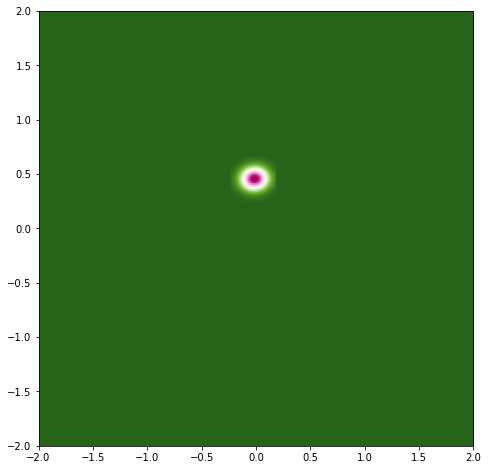

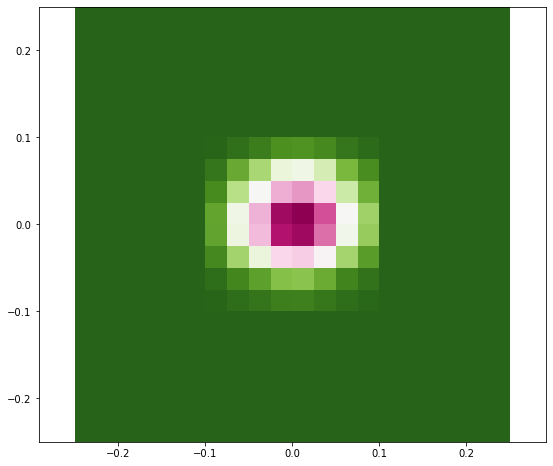

Pose estimate 0.00+/-0.04,0.008+/-0.034


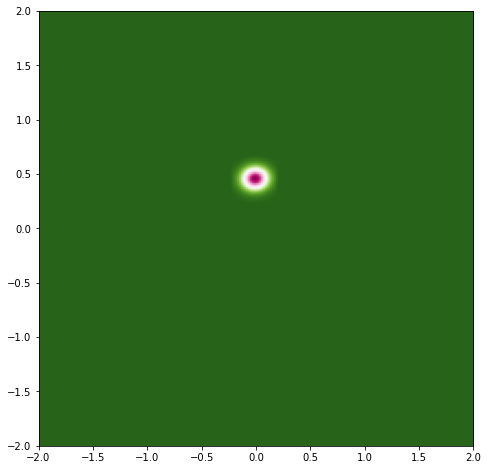

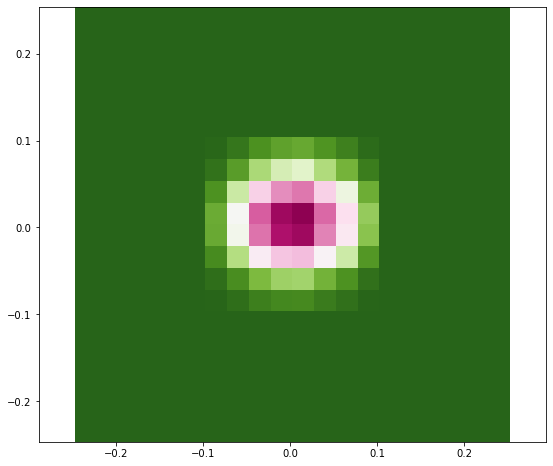

Pose estimate 0.01+/-0.04,0.01+/-0.04


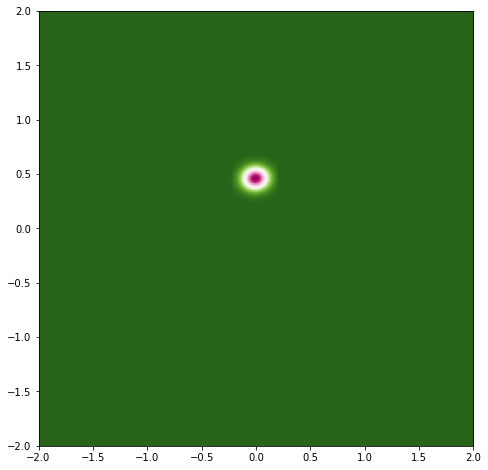

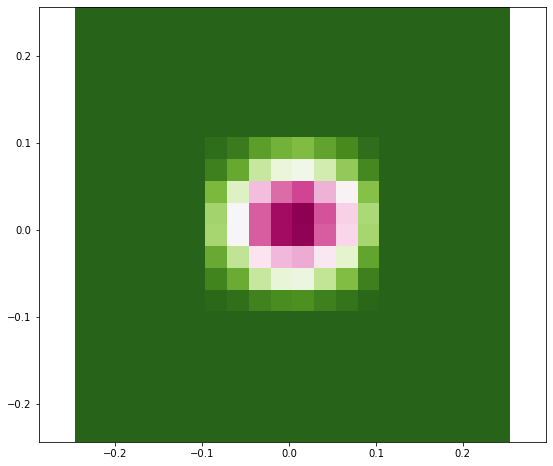

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.587255188541363, 115.62408652440807, -100.21923414206373], 'timestamp': 1.050133466720581, 'ultrasonic_sensor/last_measurement': {'average_distance': 0.22453393254961287, 'stdev_distance': 0.0024085574746049326, 'timestamp': 1615869453.0478485, 'n_averages': 14}}
Pose estimate 0.01+/-0.04,0.01+/-0.04


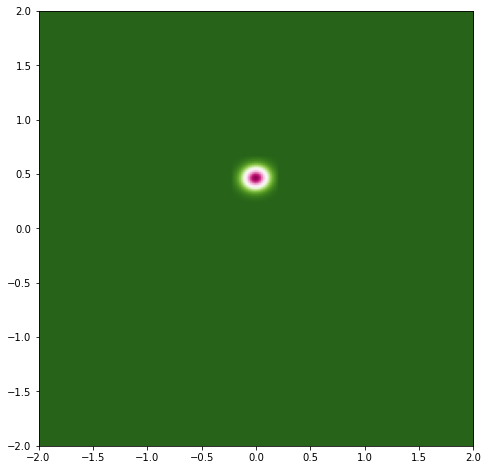

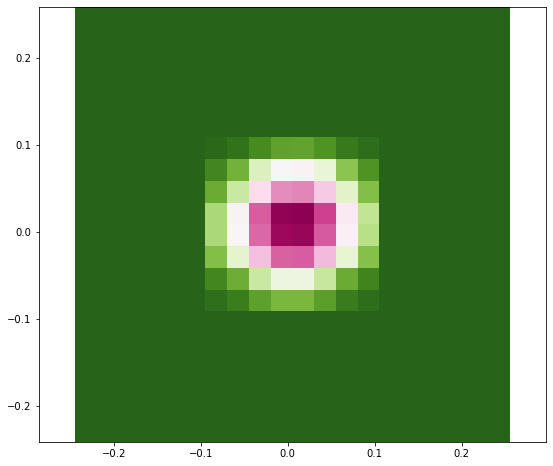

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.952645425314234, 119.6579947383806, -101.90002923121895], 'timestamp': 1.0809237957000732}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.19263373282666, 117.83104355451621, -101.08155510084771], 'timestamp': 1.1216273307800293}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.397252265419468, 120.90032154340835, -101.62233265127156], 'timestamp': 1.161525011062622}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.63724057293189, 121.6164864074832, -101.85618240280621], 'timestamp': 1.1953792572021484}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.178018123355745, 120.03800058462437, -101.5638702133879], 'timestamp': 1.2366180419921875}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.95878398129202, 12

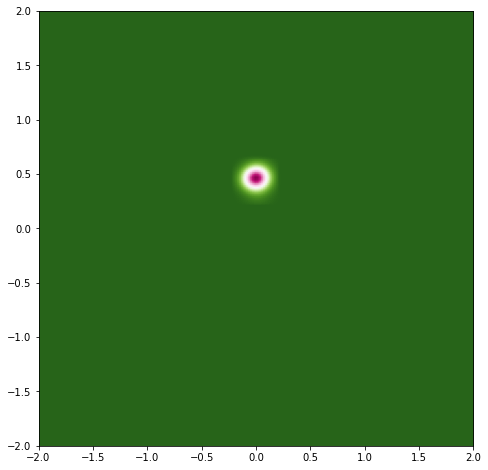

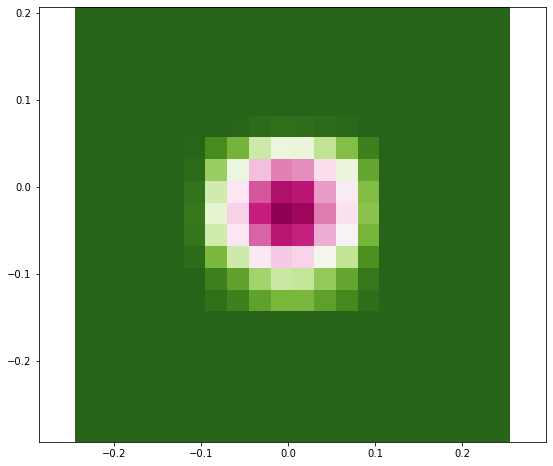

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.689564454837768, 121.95264542531423, -101.09617071031862], 'timestamp': 1.3449971675872803}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.835720549546917, 122.17187956737796, -102.07541654486991], 'timestamp': 1.3800747394561768}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.07570885705934, 120.34492838351358, -101.16924875767319], 'timestamp': 1.4120049476623535}
Pose estimate -0.00+/-0.04,-0.09+/-0.04


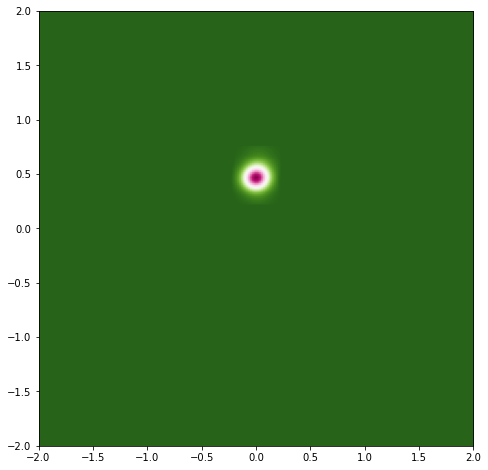

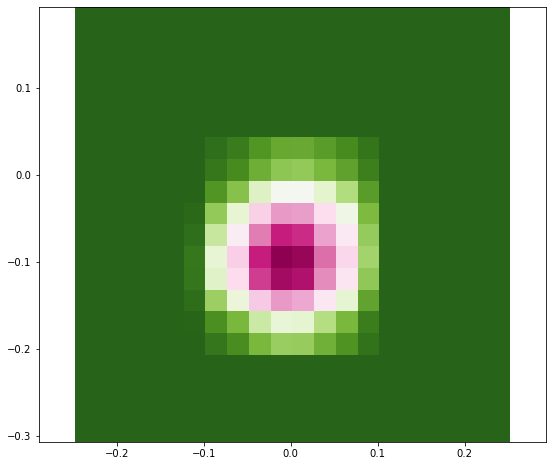

Pose estimate 0.01+/-0.04,-0.09+/-0.04


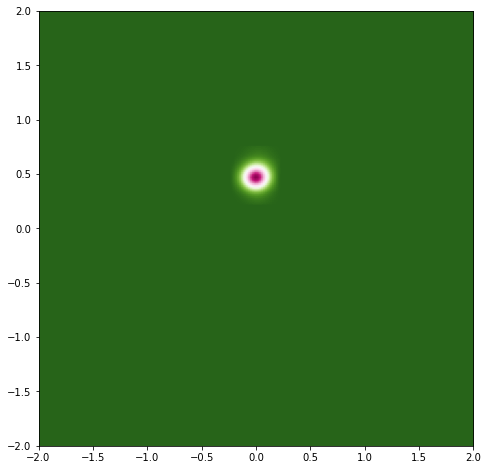

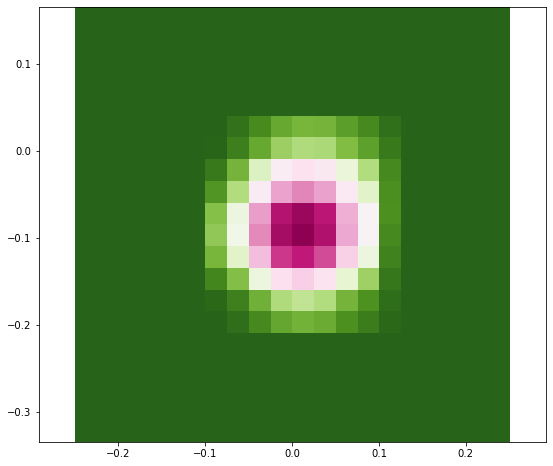

n teachable moments 1
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-22.88804443145279, 114.63022508038586, -101.92926045016077], 'timestamp': 2.0492684841156006}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.411867874890383, 121.42648348436128, -100.7015492546039], 'timestamp': 2.0812268257141113, 'ultrasonic_sensor/last_measurement': {'average_distance': 0.32838656352116513, 'stdev_distance': 0.006914690953411503, 'timestamp': 1615869454.0536175, 'n_averages': 13}}
Pose estimate 0.02+/-0.04,-0.09+/-0.04


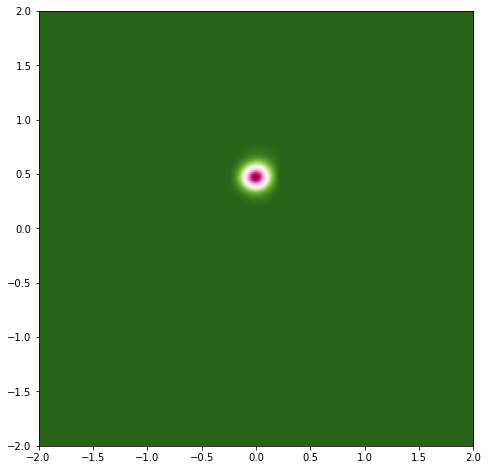

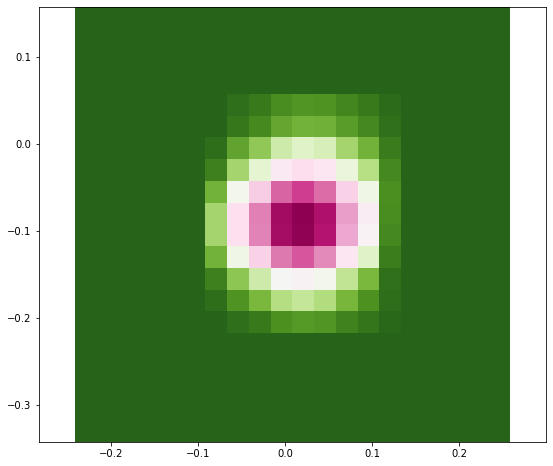

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-22.376498099970767, 120.90032154340835, -101.3592516807951], 'timestamp': 2.115645408630371}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.207249342297573, 121.41186787489038, -100.84770534931306], 'timestamp': 2.1463942527770996}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.821104940076, 122.12803273896522, -101.5638702133879], 'timestamp': 2.1787848472595215}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.119555685472083, 122.68342589886, -101.40309850920784], 'timestamp': 2.215064525604248}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.856474714995617, 123.2826658871675, -100.42385267465654], 'timestamp': 2.2475168704986572}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.34492838351359, 121.952

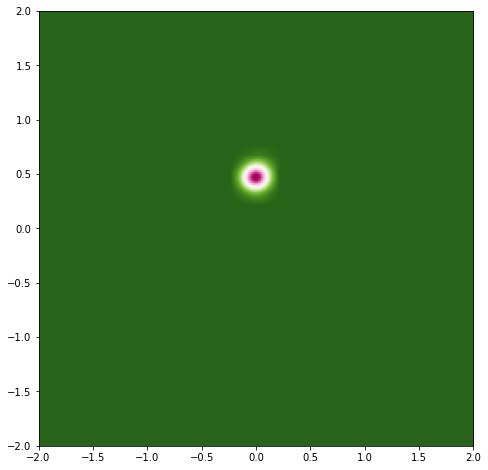

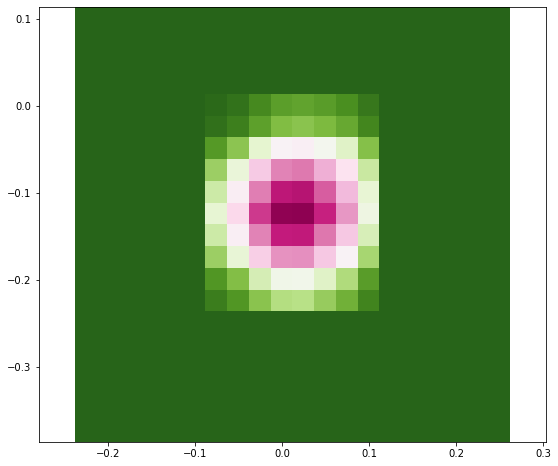

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.973399590762934, 122.11341712949431, -101.18386436714411], 'timestamp': 2.3576130867004395}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.207249342297573, 122.97573808827829, -102.32388190587547], 'timestamp': 2.3978848457336426}
Pose estimate 0.02+/-0.04,-0.18+/-0.05


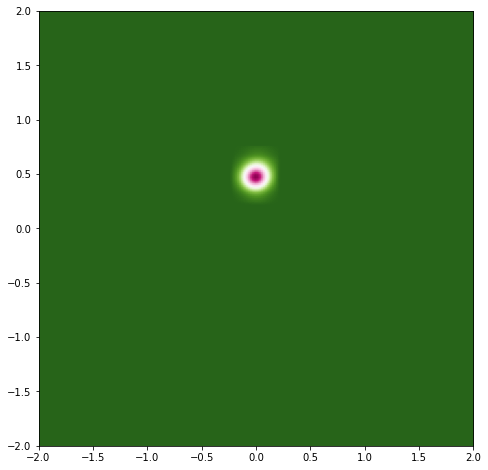

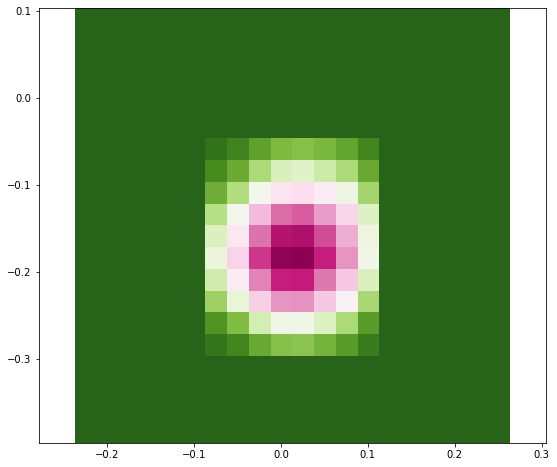

Pose estimate 0.04+/-0.04,-0.18+/-0.04


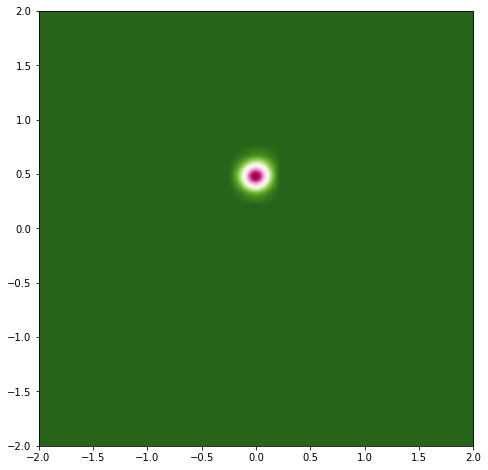

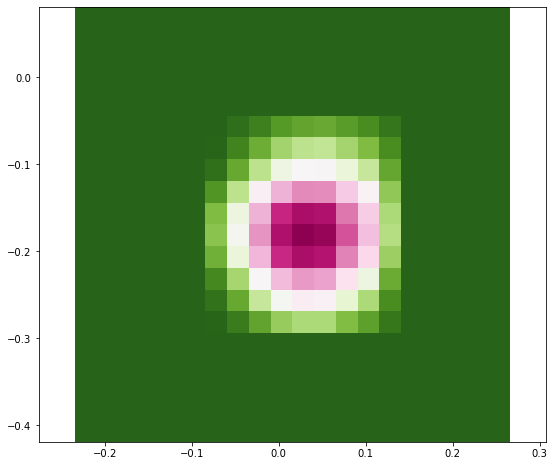

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.25109617071032, 116.25255773165742, -101.63694826074247], 'timestamp': 3.081439733505249, 'ultrasonic_sensor/last_measurement': {'average_distance': 0.424496332804362, 'stdev_distance': 0.0029146446744191127, 'timestamp': 1615869455.0521388, 'n_averages': 12}}
Pose estimate 0.05+/-0.04,-0.18+/-0.04


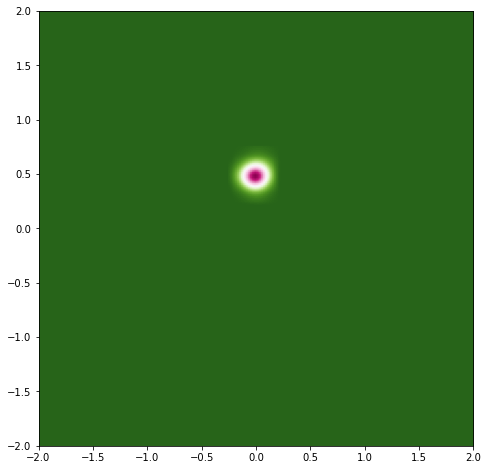

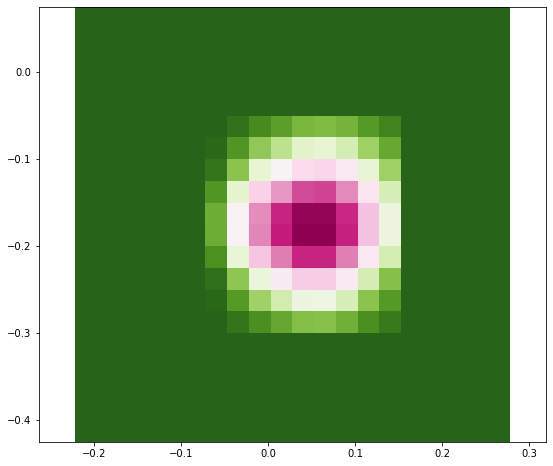

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.981876644256065, 120.47646886875182, -100.20461853259282], 'timestamp': 3.111699104309082}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.052616194095293, 123.12189418298742, -100.90616778719672], 'timestamp': 3.1467154026031494}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-21.280327389652147, 120.69570301081556, -101.84156679333529], 'timestamp': 3.1764004230499268}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.69570301081555, 123.61882490499853, -101.24232680502776], 'timestamp': 3.2127842903137207}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.491084478222742, 122.52265419467992, -101.43232972814967], 'timestamp': 3.2476186752319336}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.87109032446653

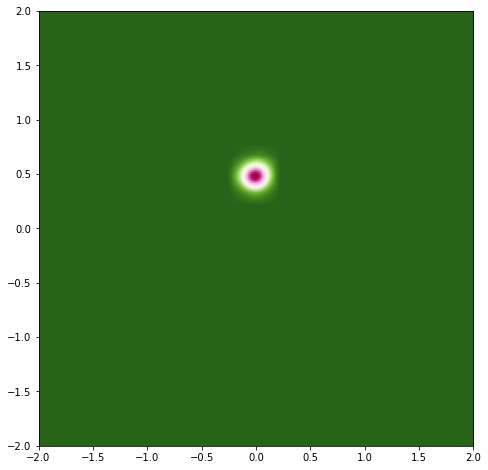

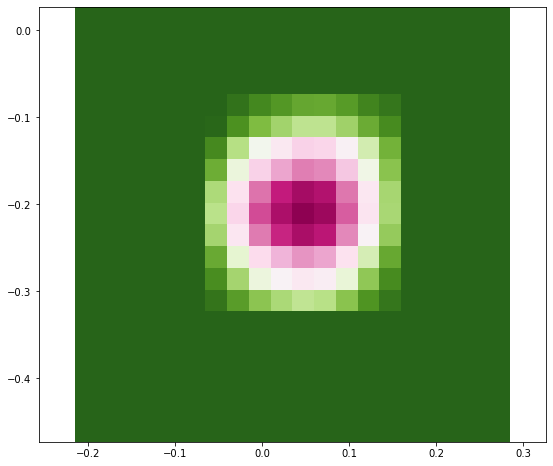

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.081847413037124, 123.22420344928385, -101.9584916691026], 'timestamp': 3.346757173538208}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.1549254603917, 123.56036246711489, -101.84156679333529], 'timestamp': 3.3765764236450195}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.768781058170124, 123.4726688102894, -101.68079508915523], 'timestamp': 3.4089951515197754}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.18415667933353, 124.72961122478807, -101.30078924291143], 'timestamp': 3.443310022354126}
Pose estimate 0.05+/-0.04,-0.27+/-0.05


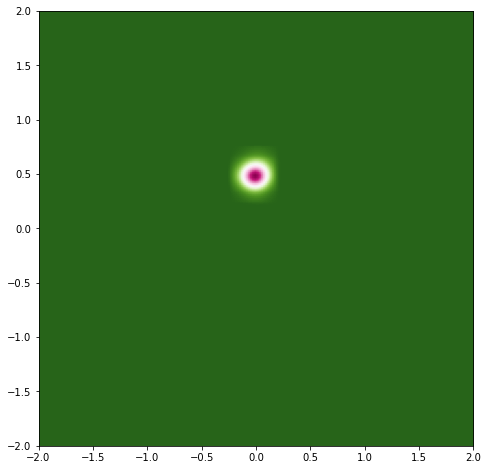

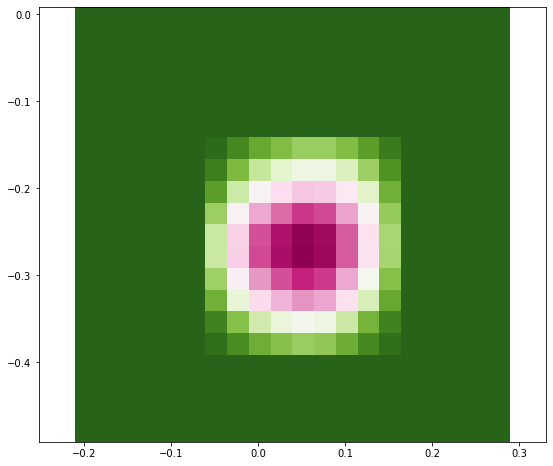

Pose estimate 0.06+/-0.05,-0.27+/-0.05


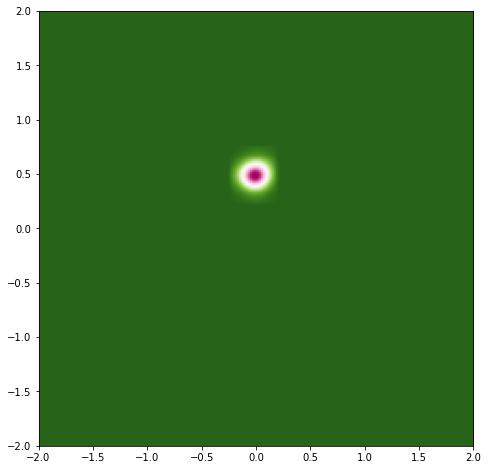

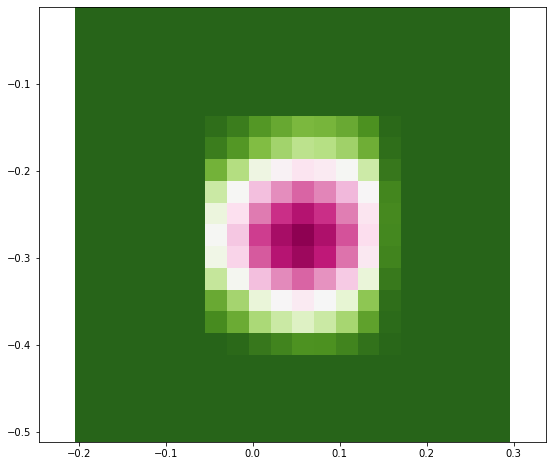

n teachable moments 3
[-0.23730926513671874, -0.23088226318359373, -0.23547792434692383]
[-0.08790141610175575, -0.08463332842228041, -0.09139883957773252]
learning ahead
before ahead slope 0.330+/-0.033
after ahead slope 0.332+/-0.033
Pose estimate 0.05+/-0.04,-0.27+/-0.04


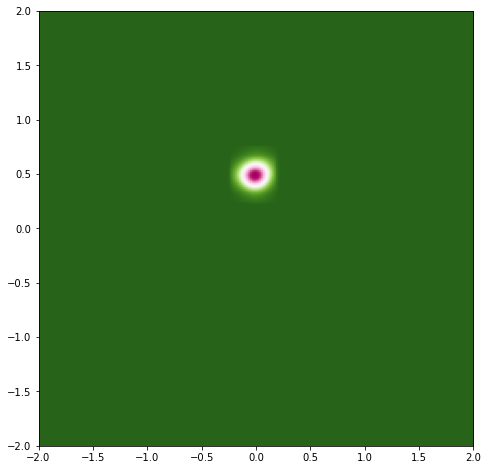

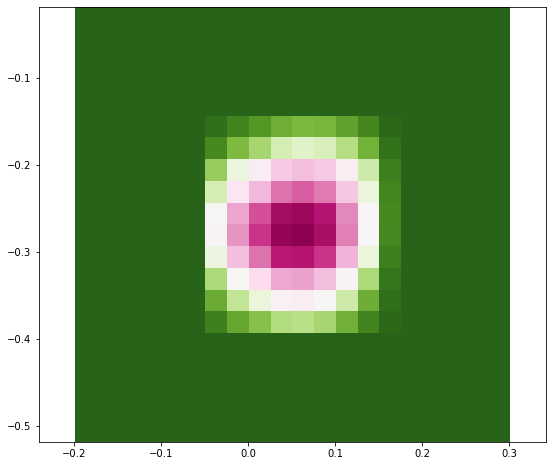

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.286465945629935, 113.81175095001461, -101.50540777550422], 'timestamp': 4.113153457641602}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.856474714995617, 122.8003507746273, -102.09003215434083], 'timestamp': 4.144656419754028}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.95878398129202, 121.82110494007601, -101.3592516807951], 'timestamp': 4.175745487213135}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.140309850920783, 122.2157263957907, -100.97924583455129], 'timestamp': 4.20967435836792}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.81262788658287, 123.72113417129493, -100.59923998830752], 'timestamp': 4.244610071182251}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.856474714995617, 123.44

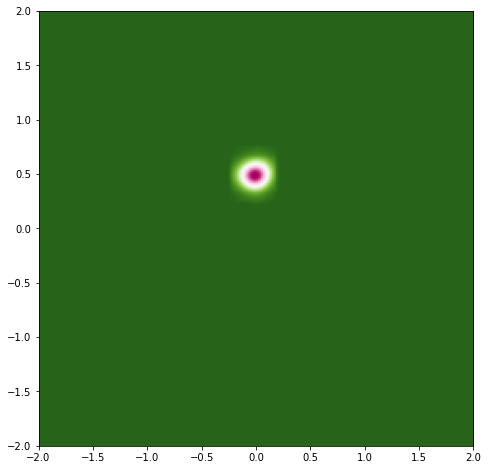

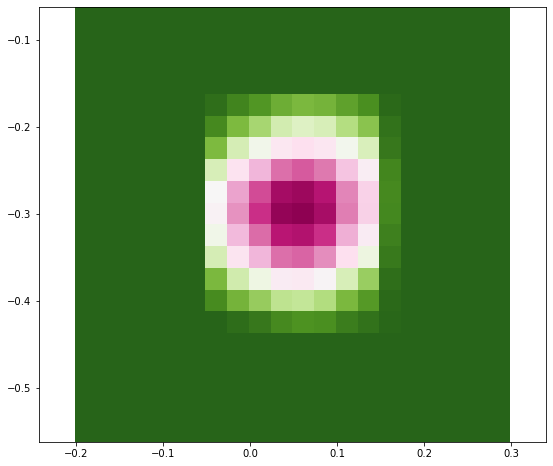

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.403390821397252, 124.20344928383513, -101.69541069862613], 'timestamp': 4.347661733627319}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.19877228880444, 123.92575270388775, -100.83308973984215], 'timestamp': 4.378962993621826}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.935691318327976, 124.74422683425898, -101.00847705349314], 'timestamp': 4.418522119522095}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.476468868751827, 124.67114878690441, -101.46156094709148], 'timestamp': 4.458597421646118}
Pose estimate 0.06+/-0.05,-0.36+/-0.04


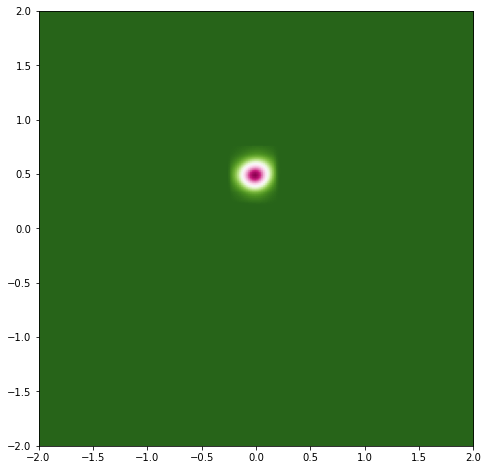

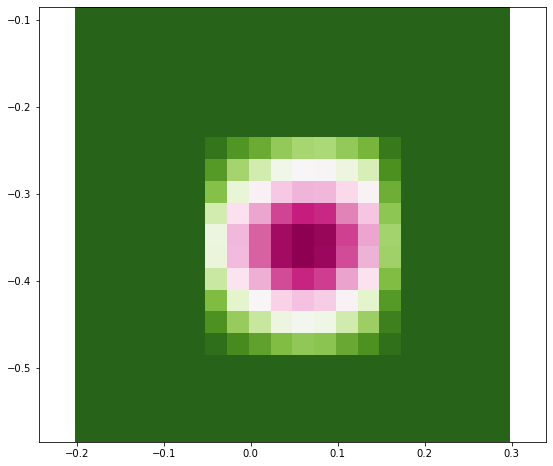

Pose estimate 0.06+/-0.05,-0.37+/-0.05


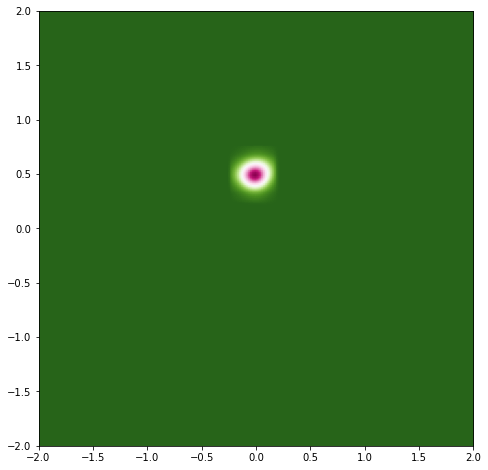

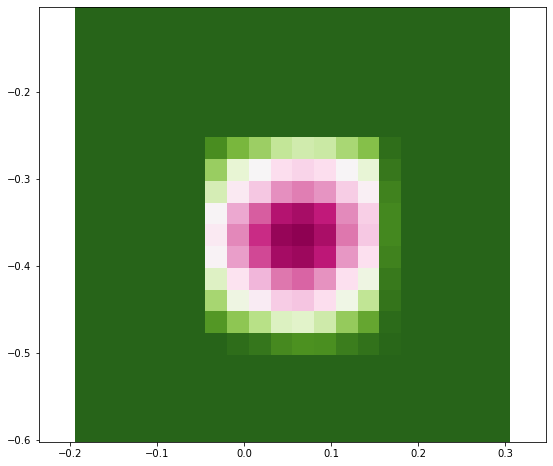

Pose estimate 0.06+/-0.05,-0.37+/-0.04


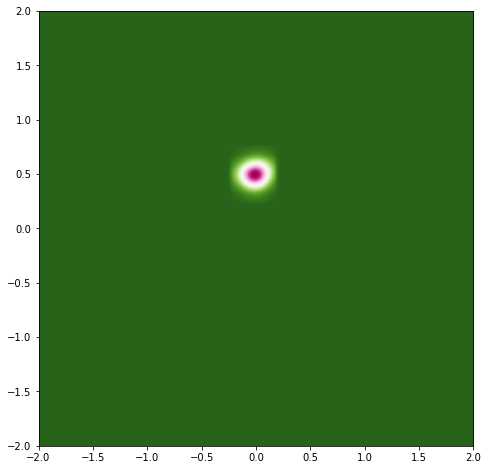

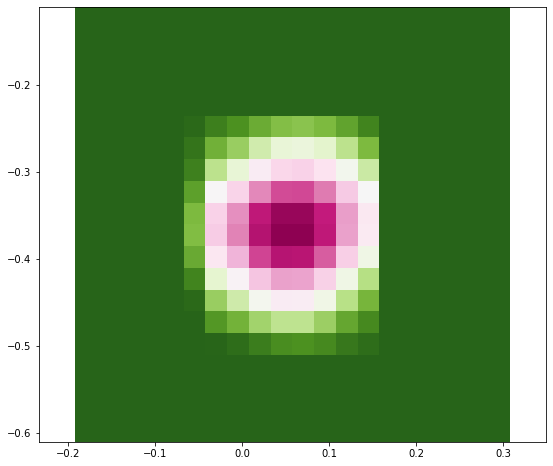

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.19877228880444, 123.66267173341127, -100.38000584624378], 'timestamp': 5.112908840179443}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.228003507746273, 123.50190002923122, -101.5638702133879], 'timestamp': 5.143496513366699}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.5495469161064, 126.3227126571178, -102.70388775211927], 'timestamp': 5.183562755584717}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.00876936568255, 123.20958783981293, -101.41771411867875], 'timestamp': 5.226600646972656}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.774919614147908, 123.91113709441683, -101.92926045016077], 'timestamp': 5.256173610687256}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.00876936568255, 123.925

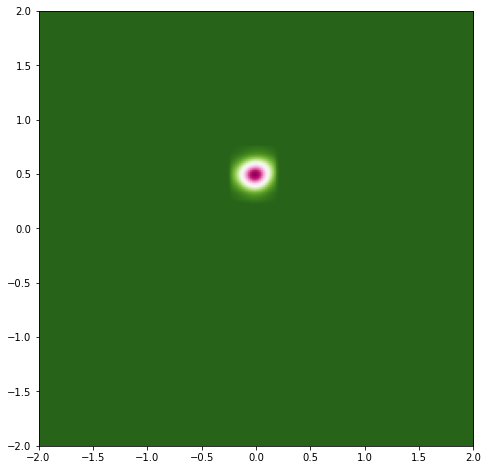

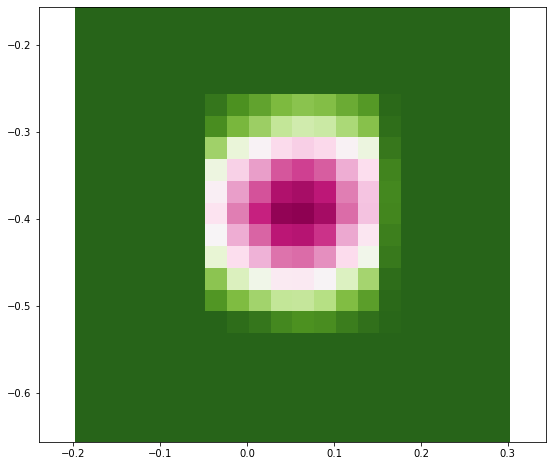

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.83338205203157, 124.53960830166618, -100.80385852090032], 'timestamp': 5.372995853424072}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.59953230049693, 123.96959953230049, -101.16924875767319], 'timestamp': 5.409371614456177}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.26337328266589, 124.87576731949723, -101.0669394913768], 'timestamp': 5.442625522613525}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.877228880444314, 124.86115171002632, -100.62847120724933], 'timestamp': 5.478281497955322}
Pose estimate 0.08+/-0.05,-0.45+/-0.04


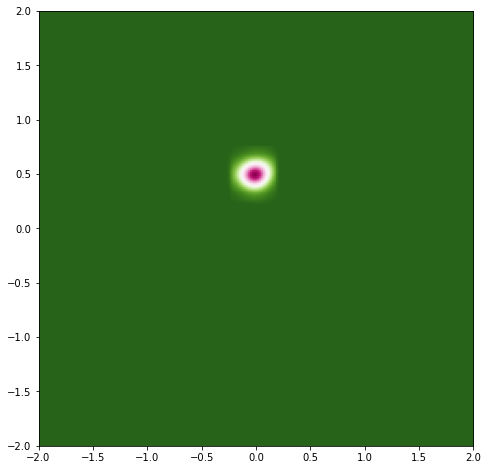

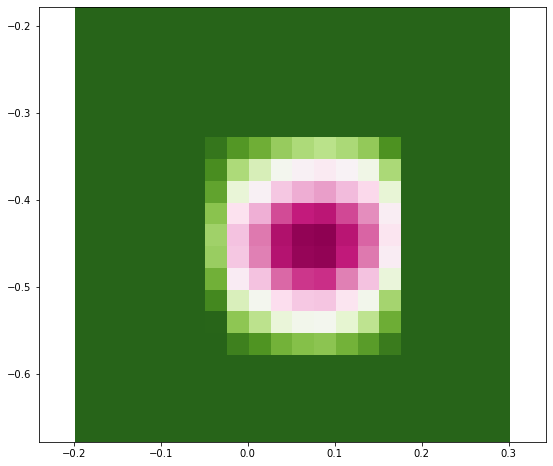

Pose estimate 0.11+/-0.05,-0.47+/-0.05


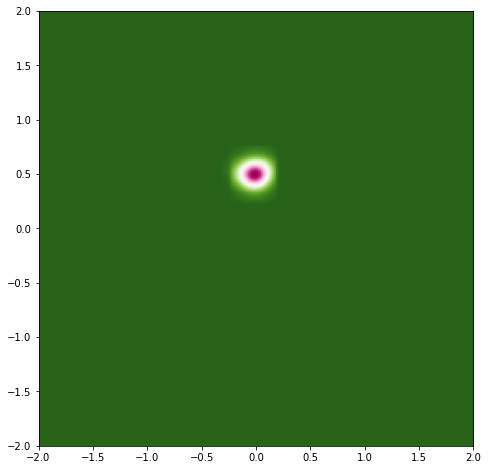

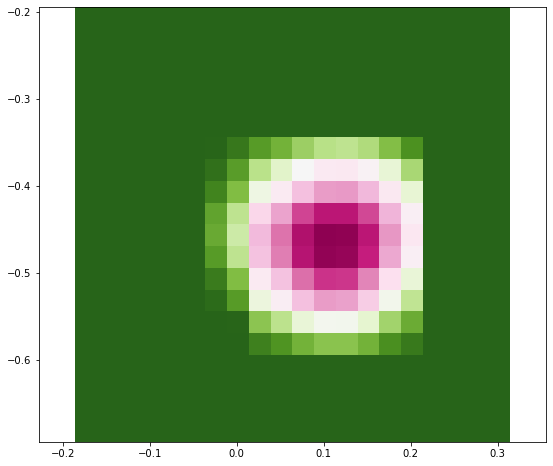

n teachable moments 2
[-0.2310709476470947, -0.23884177207946777]
[-0.08892383447829065, -0.09017064924086614]
learning ahead
before ahead slope 0.332+/-0.033
after ahead slope 0.333+/-0.033
Pose estimate 0.14+/-0.05,-0.46+/-0.05


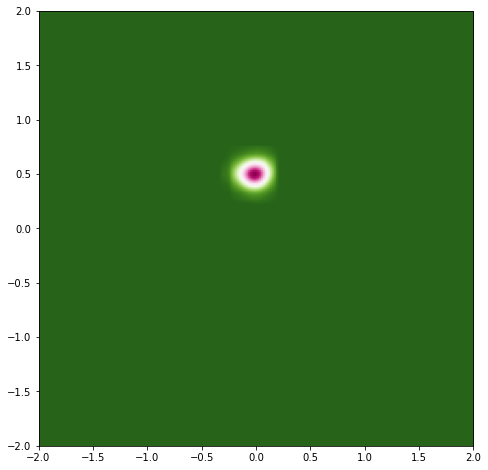

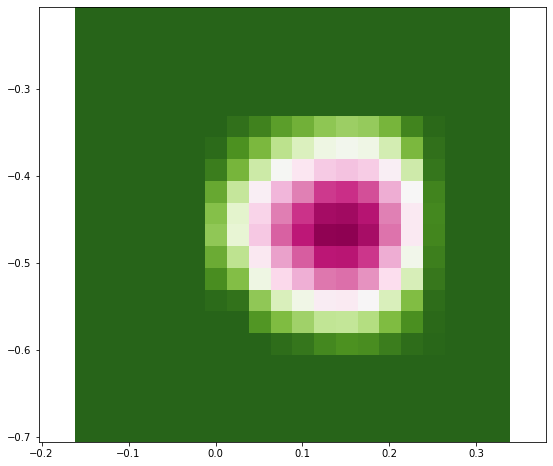

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.409529377375037, 120.37415960245544, -103.37620578778134], 'timestamp': 6.111605405807495}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-18.985676702718504, 123.61882490499853, -101.08155510084771], 'timestamp': 6.152133941650391}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.856474714995617, 125.00730780473546, -101.78310435545161], 'timestamp': 6.1911396980285645}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.672610347851503, 125.6357790119848, -101.00847705349314], 'timestamp': 6.222350120544434}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.74568839520608, 124.40806781642794, -101.79771996492252], 'timestamp': 6.254035472869873}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.526454253142354, 1

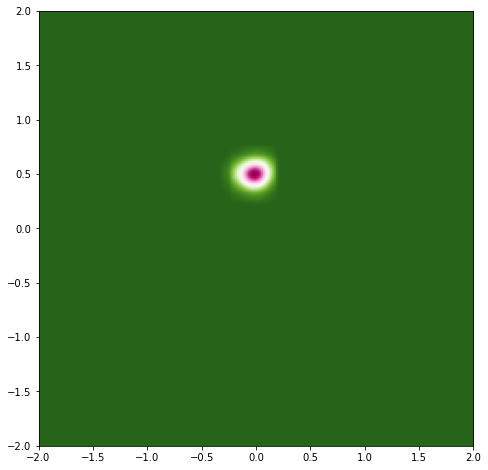

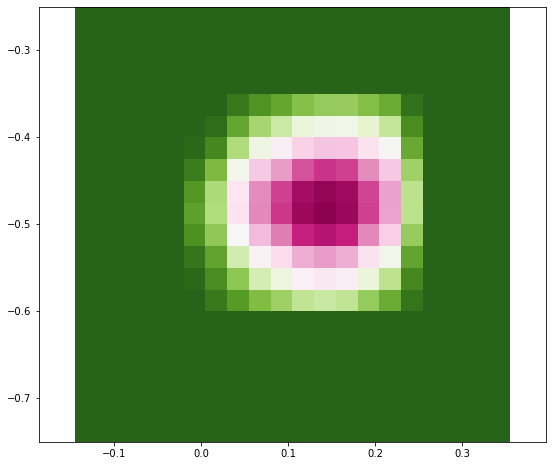

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.62876351943876, 126.46886875182695, -101.87079801227712], 'timestamp': 6.358739137649536}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-18.985676702718504, 124.90499853843906, -103.0254311604794], 'timestamp': 6.389698028564453}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-18.327974276527332, 124.77345805320081, -101.85618240280621], 'timestamp': 6.420675992965698}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.45337620578778, 126.3080970476469, -101.7684887459807], 'timestamp': 6.451164960861206}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.336451330020463, 124.4665302543116, -101.2715580239696], 'timestamp': 6.486380577087402}
Pose estimate 0.16+/-0.05,-0.56+/-0.05


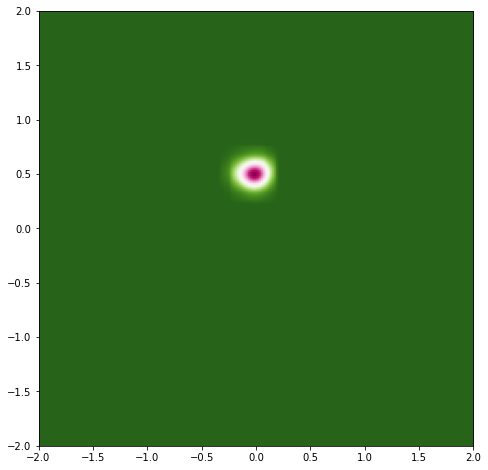

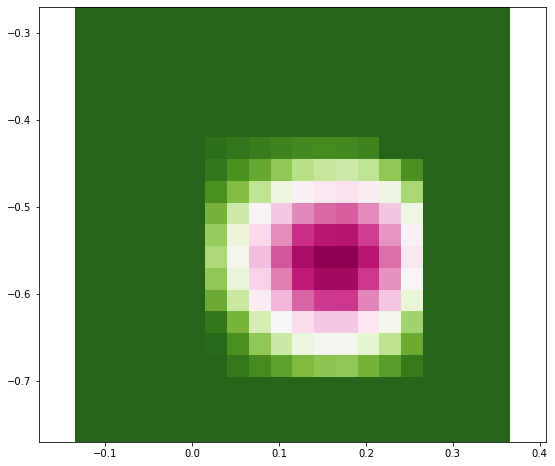

Pose estimate 0.12+/-0.05,-0.57+/-0.05


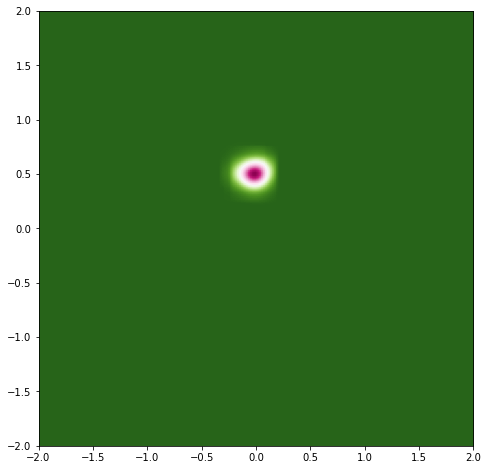

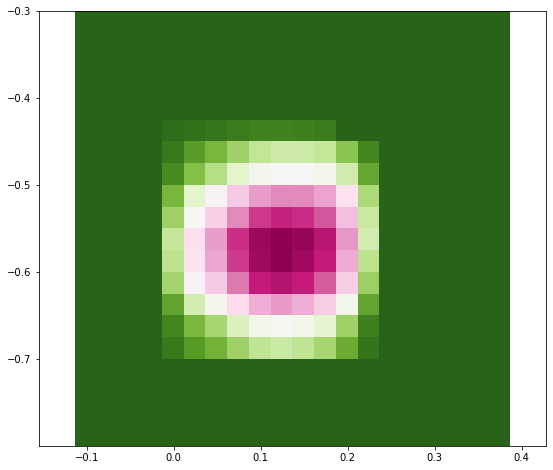

Pose estimate 0.10+/-0.05,-0.58+/-0.05


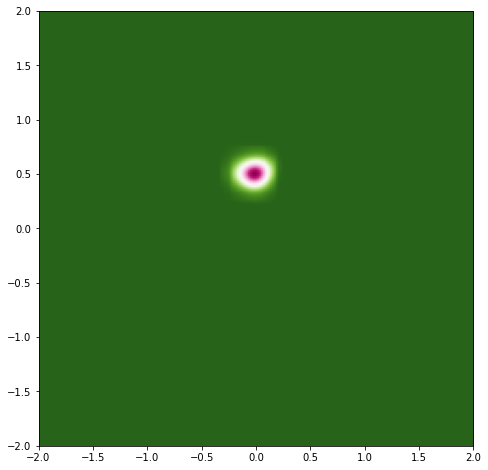

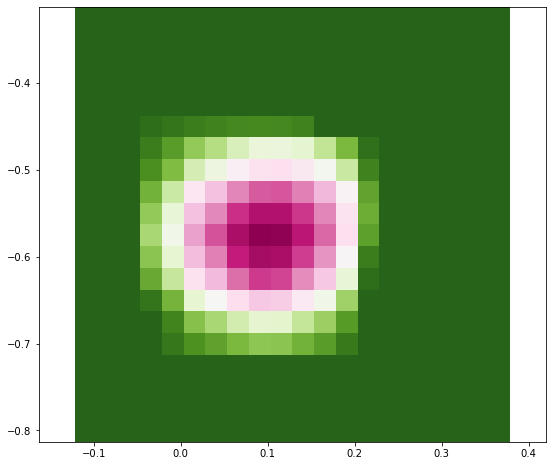

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.914937152879276, 127.28734288219819, -100.48231511254019], 'timestamp': 7.134607553482056}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-20.681087401344637, 121.45571470330312, -100.51154633148202], 'timestamp': 7.167683124542236}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.847997661502482, 122.84419760304004, -101.6661794796843], 'timestamp': 7.2018725872039795}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-18.70798012277112, 126.3080970476469, -101.3592516807951], 'timestamp': 7.242783546447754}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.511838643671442, 123.91113709441683, -101.62233265127156], 'timestamp': 7.275697708129883}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.89184448991523, 123.

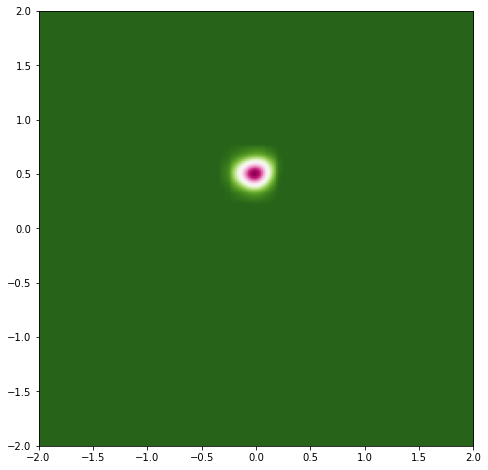

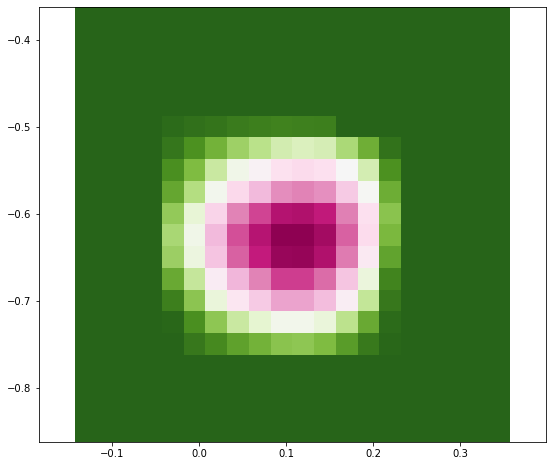

got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.526454253142354, 125.09500146156094, -101.373867290266], 'timestamp': 7.375486135482788}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.438760596316868, 125.2411575562701, -100.95001461560946], 'timestamp': 7.407240390777588}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.526454253142354, 126.2350190002923, -100.76001169248758], 'timestamp': 7.443945407867432}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.190295235311314, 125.431160479392, -101.08155510084771], 'timestamp': 7.476231336593628}
got an ahead message {'drive/motors_active': [-0.6, 0, 0], 'magnetometer/b_field': [-19.2779888921368, 124.7588424437299, -101.5638702133879], 'timestamp': 7.517472267150879}
Pose estimate 0.13+/-0.05,-0.66+/-0.05


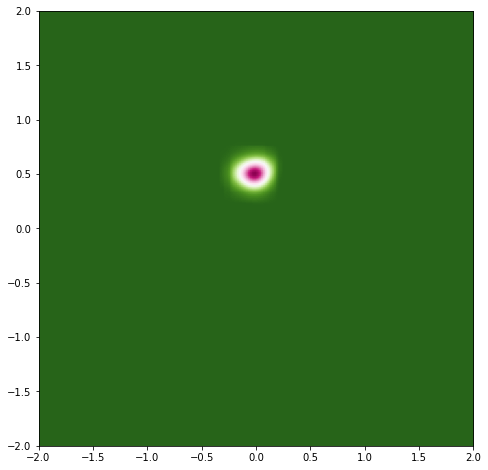

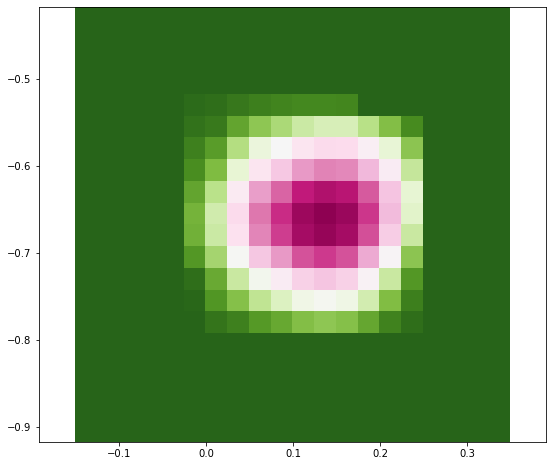

In [4]:
from PoseTrackerGyrus import PoseTrackerGyrus
from MotionGyrus import MotionEstimationGyrus

plotters={}
plotters["compass_heading"]=Plotter("compass_heading","Compass Heading","Degrees")
plotters["ultrasonic"]=UltrasonicPlotter()
plotters["pose"]=PosePlotter()
plotters["aheadmotor"]=MotorPlotter()


gyrii=[]
gyrii.append(PoseTrackerGyrus())
motionestimationgyrus=MotionEstimationGyrus()
gyrii.append(motionestimationgyrus)
localmapgyrus=LocalMapGyrus(resolution=0.01,npoints_x=200,npoints_y=200)
gyrii.append(localmapgyrus)
gyrii.append(LocalMapPlotter(localmapgyrus))

for key in plotters:
    gyrii.append(plotters[key])
    
#Load existing config file into the gyrii
config_filename="../gyrus_config.yaml"
try:
    with open(config_filename,'r') as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
        for g in gyrii:
            g.load_config(data)
        f.close()
except:
    print("Unable to load gyrus config file")



#inspect_messagename="timestamp"
inspect_messagename="none"
remove_messages=["pose_offset"]
start_timestamp=sensor_log[0]["timestamp"]
for i in range(len(sensor_log)):    
    for m in remove_messages:
        if m in sensor_log[i]:            
            #print("removing {}".format(sensor_log[i]))            
            sensor_log[i].pop(m,None)
            #print("removing {}".format(sensor_log[i]))                        
    start_message=sensor_log[i]
    start_message["timestamp"]-=start_timestamp #rescale time to zero at start
    waiting_messages=[ start_message ]    
    while len(waiting_messages)!=0:
        on_message=waiting_messages.pop()
        if inspect_messagename in on_message:
            print(on_message)
        for g in gyrii:
            waiting_messages.extend(g.read_message(on_message))
        
#for key in plotters:
#    plotters[key].dataseries.times=plotters[key].dataseries.times-start_timestamp

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab

[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6
 -0.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.  -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6
 -0.6 -0.6 -0.6 -0.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  -0.6 -0.6 -0.6 -0.6 -0.6 -0.6
 -0.6 -0.6 -0.6 -0.6 -0.6  0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.6 -0.6 -0.6 -0.6 -0.6
 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6  0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.6 -0.6 -0.6 -0.6 -0.6
 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6 -0.6  0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.

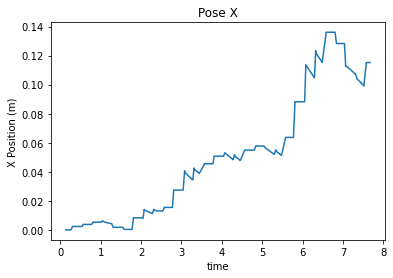

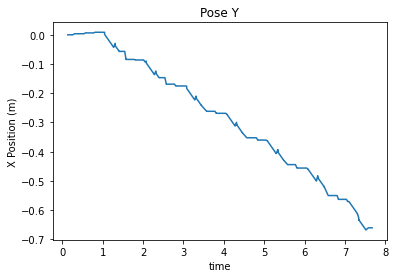

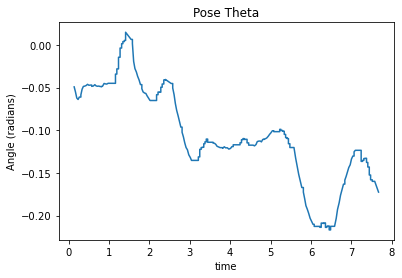

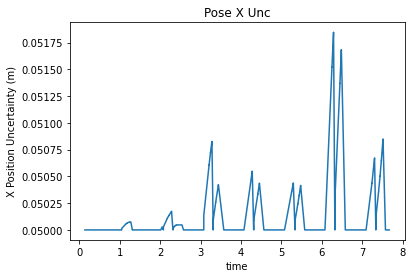

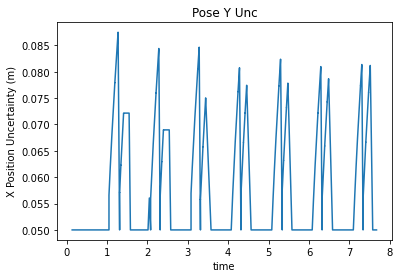

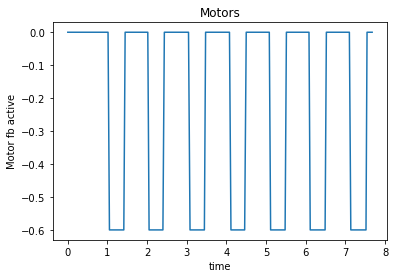

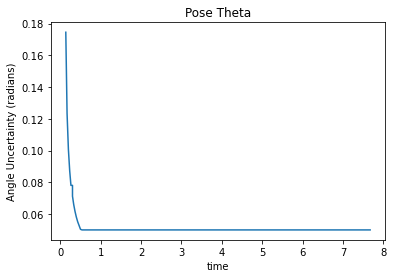

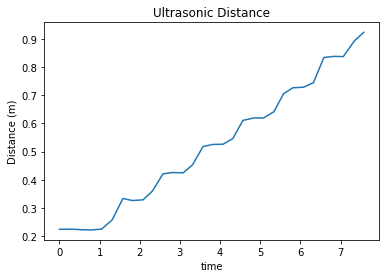

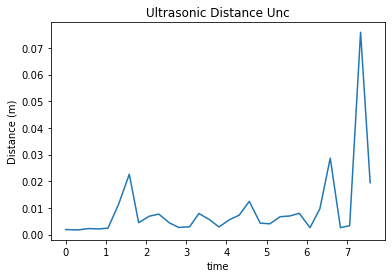

In [5]:
plotters["pose"].x_dataseries.plot()
plotters["pose"].y_dataseries.plot()
plotters["pose"].theta_dataseries.plot()
plotters["pose"].x_unc_dataseries.plot()
plotters["pose"].y_unc_dataseries.plot()
plotters["aheadmotor"].dataseries.plot()
#print(plotters["pose"].y_unc_dataseries.data)
print(plotters["aheadmotor"].dataseries.data)

plotters["pose"].theta_unc_dataseries.plot()
plotters["ultrasonic"].dataseries.plot()
plotters["ultrasonic"].dataseries_unc.plot()



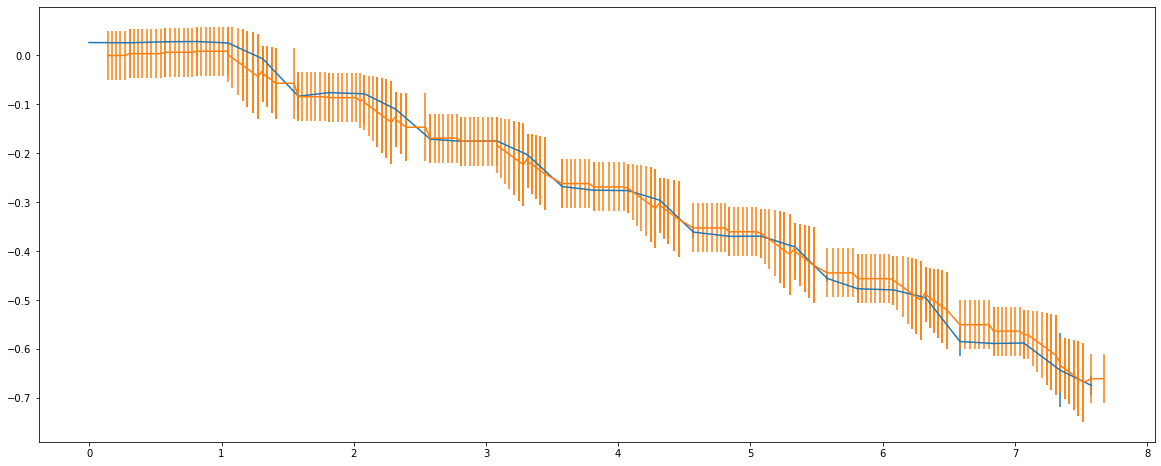

In [6]:
plt.figure(figsize=(20,8))
plt.errorbar(plotters["ultrasonic"].dataseries.times,0.25-plotters["ultrasonic"].dataseries.data,yerr=plotters["ultrasonic"].dataseries_unc.data)
plt.errorbar(plotters["pose"].y_dataseries.times,plotters["pose"].y_dataseries.data,yerr=plotters["pose"].y_unc_dataseries.data)
plt.show()

AttributeError: 'LocalMapGyrus' object has no attribute 'gridmap_occupied'

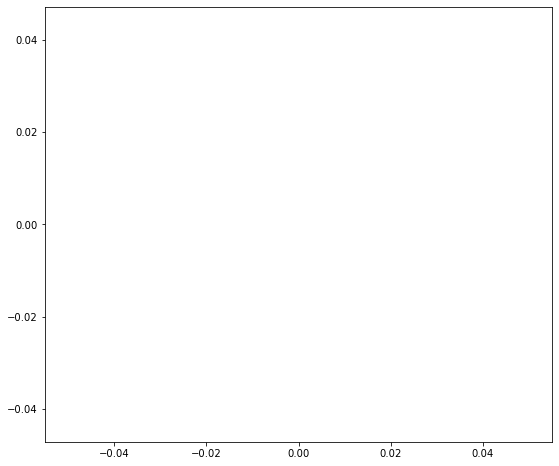

In [7]:

#localmapgyrus.gridmap_occupied[150,100]=10


def plot_map(mapgyrus):
    plt.figure(figsize=(20,8))
    plt.subplot(122)
    plt.axis("equal")
    extent=0.5*mapgyrus.npoints_x*mapgyrus.resolution
    plt.imshow(mapgyrus.gridmap_occupied.T[::-1,:], cmap = "PiYG_r",extent=[-extent,extent,-extent,extent]) 

plot_map(localmapgyrus)
print(localmapgyrus.gridmap_occupied)

In [ ]:
break
#save the results
config_object={}
for g in gyrii:
    config_object.update(g.save_config())

config_filename="../gyrus_config.yaml"

with open(config_filename,'w') as f:
        data = yaml.dump(config_object,f)                
        f.close()